In [11]:
import numpy as np                                     
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
import pandas as pd
import scipy.signal as scy
import scipy.optimize as optimization
from scipy.io import savemat
from scipy.integrate import odeint, solve_ivp

INPUT_FILE_DIR="Input_data/"
OUTPUT_FILE_DIR = "Output_data/"
OUTPUT_FILE_DIR_NEW = "Output/"
fig_path = "Figures/"

import sys
sys.path.append('../Multiple_pulses_experiments_and_model/Multiple_pulses_experiments')
from Functions_for_plot_style import *
sys.path.append('../../')
from Functions_common_for_model_and_experiments import *
%load_ext autoreload
%autoreload 2

from Single_pulses_pars import *

p53_color_pre_nutlin = "#a31621ff"
p53_color_post_nutlin = "#053c5eff"
mdm2_color = "#bf8124ff"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Unperturbed trace example in the model

Mean period [h]:  5.504000000000219


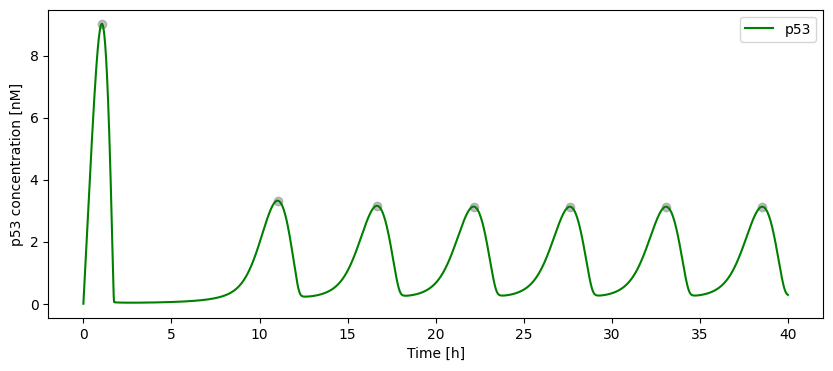

In [7]:
simT = 40 # [h]
maxstep = 0.01 # [h]

# New trace
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars_exp)
solution = solve_ivp(f_p53, [0, simT], [0,0,0], max_step = maxstep, method = 'RK45', args = (kc1,kc20,kc3,kc4,kc5,kc6,kc7))

# Plots
plt.figure(figsize=(10,4))
peaks, _ = find_peaks(solution.y[2], prominence=0.1)
plt.plot(solution.t, solution.y[2], color = "green", alpha = 1, label = "p53")
#plt.plot(sol_old.t, sol_old.y[1], color = "tab:orange", alpha = 0.5, label = "Mdm2 old")
plt.scatter(solution.t[peaks], solution.y[2,peaks], color = "gray", alpha = 0.5)

plt.legend()
plt.xlabel("Time [h]")
plt.ylabel("p53 concentration [nM]")

print("Mean period [h]: ",np.mean(np.diff(solution.t[peaks[1:]])))

plt.show()

# Model: simulate single pulses over range of initial phases and nut constants

In [12]:
kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars_exp)
x0, dt, simT, kc8, nut_const_vec_model = unpack_sim_pars_list(simulation_parameters)
t = np.arange(0, simT, dt)

dataset_list_model = []

for nut_ith,f_k2  in enumerate(nut_const_vec_model):
    jvec = np.linspace(0,5.5,num = 20) # Nutlin is delivered to num cells at different phases
    for ind,j in enumerate(jvec): # loop over num cells
        
        tstart_nut = simT/2+j # Start of nutlin pulse [h]
        tend_nut = simT #tstart_nut+t_ON       
        x, kc2 = odeRungeKutta4_p53_single_pulse(f_p53,x0,dt,simT, f_k2, kc8, tstart_nut, tend_nut, kc1, kc20,kc3,kc4,kc5,kc6,kc7)
        dataset_list_model.append(
            {"cell_id": ind, 
             "time":t,
             "p53_trace": x[:,2],
             "mdm2_trace": x[:,1],
             "nut_trace": kc2,
            "time_nut_on":tstart_nut,
            "time_nut_off":tend_nut,
            "nut_conc": f_k2}
        )        
        
dataset_model = pd.DataFrame(dataset_list_model)
dataset_model.to_pickle(OUTPUT_FILE_DIR_NEW+"Theoretical_data_new_exp_decay.pkl")     # Save dataset   

In [13]:
# Load the saved dataset and compute PTC and PRC

dataset_model = pd.read_pickle(OUTPUT_FILE_DIR_NEW+"Theoretical_data_new_exp_decay.pkl")
dataset_model = dataset_model.apply(compute_PTC, args = (1,"p53_trace", None, 0.1), axis = 1)
dataset_model = dataset_model.apply(compute_PRC_from_PTC, axis = 1)

# Experiments

In [14]:
nut_conc_vec_exp = [0.125,0.25,0.5,1,2]
dataset_list_exp = []

# I create a unique pandas dataframe from the txt files and I apply the smooth filter

for n in np.arange(0,len(nut_conc_vec_exp),1): #### Choose external frequency   
    # Load the data
    title = "p53_from_measurements_YFP_at"+str(nut_conc_vec_exp[n])+"uM.txt"
    matrix_of_traces = np.array(pd.read_csv(OUTPUT_FILE_DIR+title, delimiter=',',header=None))
    t = np.arange(0, matrix_of_traces.shape[1]) # in num of steps
    for cell in range(matrix_of_traces.shape[0]):
        dataset_list_exp.append(
            {"filename": title,
             "cell_id": cell, 
             "time":t,
             "p53_trace":matrix_of_traces[cell,:],
            "time_nut_on": 187, #188, (188 was in Matlab where index starts from 1)
            "time_nut_off": 191, #192, (188+ 4 steps which is 40 mins)
            "nut_conc": nut_conc_vec_exp[n]}
        )
dataset_exp = pd.DataFrame(dataset_list_exp)
dataset_exp = dataset_exp.apply(smooth_filter, axis = 1) # Here I smooth the data
dataset_exp.to_pickle(OUTPUT_FILE_DIR+"Experimental_data_from_measurements_YFP.pkl")

In [15]:
group_sizes = dataset_exp.groupby(['nut_conc']).size()

In [16]:
group_sizes

nut_conc
0.125     98
0.250    110
0.500    106
1.000    108
2.000    105
dtype: int64

### Figure 1B

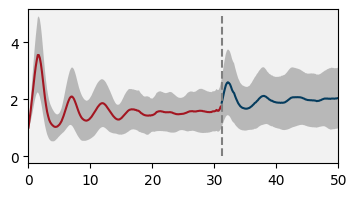

In [17]:
# Mean p53 trace at 1uM
nut_conc = 1.0
time_nut_on = dataset_exp[dataset_exp["nut_conc"]==1.0]["time_nut_on"].reset_index(drop=True)[0]/6
time = np.mean(dataset_exp[dataset_exp["nut_conc"]==nut_conc]["time"])/6
mean_p53 = np.mean(dataset_exp[dataset_exp["nut_conc"]==nut_conc]["p53_trace_smooth"])
mean_p53_pre_nutlin = mean_p53[time<time_nut_on]
mean_p53_post_nutlin = mean_p53[time>=time_nut_on]
std_p53 = np.std(np.array(dataset_exp[dataset_exp["nut_conc"]==1.0]["p53_trace_smooth"]))

fig,ax = plt.subplots(figsize=(4,2))
plt.plot(time[time<time_nut_on],mean_p53_pre_nutlin, color = p53_color_pre_nutlin)
plt.plot(time[time>=time_nut_on],mean_p53_post_nutlin, color = p53_color_post_nutlin)
plt.fill_between(time,mean_p53-std_p53,mean_p53+std_p53, alpha = 0.5, facecolor = "gray", edgecolor = None)
plt.vlines(time_nut_on, 0, max(mean_p53+std_p53), linestyles="--",color = "gray")
plt.xlim(left = 0, right=50)
ax.set_facecolor(color_background_exp)
plt.savefig("./Figures/mean_p53_1uM.svg")
plt.show()

In [18]:
# I compute the PTC and PRC from the experimental traces

dataset_exp = pd.read_pickle(OUTPUT_FILE_DIR+"Experimental_data_from_measurements_YFP.pkl")
dataset_exp = dataset_exp.apply(compute_PTC, args = (1,"p53_trace_smooth", 20), axis = 1)
dataset_exp = dataset_exp.apply(compute_PRC_from_PTC, axis = 1)

# Plot PRCs and PTCs of model vs experimental data

## Figure 1G-1I

In [19]:
def find_cell_at_phase0(dataset,nut_conc,phase0):

    cond = dataset["nut_conc"]== nut_conc

    subset = dataset.loc[cond].reset_index(drop=True)
    
    subset['sort_condition'] = abs(subset["phase0"]-phase0)

    # Sort the DataFrame based on the new column
    sorted_df = subset.sort_values(by='sort_condition')

    # Drop the sort_condition column if you don't need it anymore
    sorted_df.drop(columns='sort_condition', inplace=True)
    return sorted_df.reset_index(drop=True)

    # for i in range(num_cells):
    #     p53_trace = subset["p53_trace"][i]
    #     time = subset["time"][i]
    #     tstart_nut = subset["time_nut_on"][i]
    #     tend_nut = subset["time_nut_off"][i]
    #     PRC = subset["PRC"][i]
    #     PTC = subset["phase1"][i]
    #     phase0 = subset["phase0"][i]
    #     if mdm2_bool:
    #         mdm2_trace = subset["mdm2_trace"][i]
    #         return p53_trace, mdm2_trace, time, tstart_nut, tend_nut, PRC, PTC,phase0
    # else:
    #     return p53_trace, time, tstart_nut, tend_nut, PRC, PTC,phase0

In [20]:
single_cell_phases = [0.5,2.03,4.6]

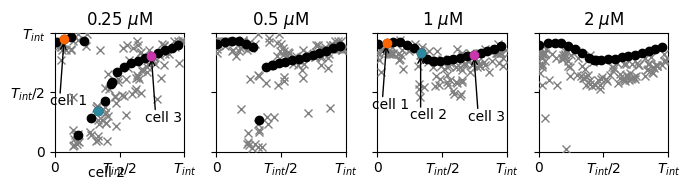

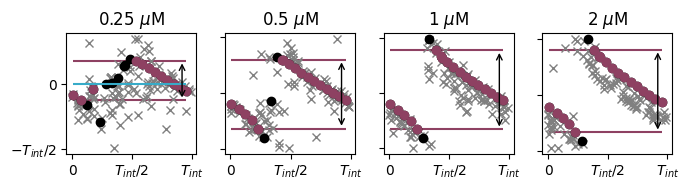

In [21]:
PRC_lightblue = 0
colorvec = ["#ff6600ff", "#2c89a0ff", "#c837abff"]
shift_annot = [-0.2,0,0.2]
fig, axs = plt.subplots(1,len(nut_const_vec_model)-1, figsize=(7,2))
for nut_ith,nut_conc  in enumerate(nut_const_vec_model):
    if nut_ith>0:
        phase0vec_model = dataset_model.loc[dataset_model["nut_conc"]==nut_conc,"phase0"].reset_index(drop=True)
        phase1vec_model = dataset_model.loc[dataset_model["nut_conc"]==nut_conc,"phase1"].reset_index(drop=True)
        PRC_model = dataset_model.loc[dataset_model["nut_conc"]==nut_conc,"PRC"].reset_index(drop=True)

        nut_conc_exp = nut_conc_vec_exp[nut_ith]
        phase0vec_exp = dataset_exp.loc[dataset_exp["nut_conc"]==nut_conc_exp,"phase0"].reset_index(drop=True)
        phase1vec_exp = dataset_exp.loc[dataset_exp["nut_conc"]==nut_conc_exp,"phase1"].reset_index(drop=True)
        PRC_exp = dataset_exp.loc[dataset_exp["nut_conc"]==nut_conc_exp,"PRC"].reset_index(drop=True)

        plot_PTC(axs[nut_ith-1],nut_ith, phase0vec_exp,phase1vec_exp,nut_conc_exp, 'x',"gray")   

        plot_PTC(axs[nut_ith-1],nut_ith, phase0vec_model,phase1vec_model,nut_conc_exp,'o',"black")
        if nut_ith == 3 or nut_ith==1:
            for i in range(len(single_cell_phases)):

                ordered_subset = find_cell_at_phase0(dataset_model,nut_conc,single_cell_phases[i])
                phase0 = ordered_subset["phase0"][0]
                PTC = ordered_subset["phase1"][0]

                axs[nut_ith-1].scatter(phase0,PTC, color = colorvec[i], zorder = 400)
                axs[nut_ith-1].annotate('', xy=(phase0+shift_annot[i], PTC-3), xytext=(phase0, PTC),
                    arrowprops=dict(arrowstyle='<-', color='black'), zorder = 100)
                axs[nut_ith-1].annotate('cell '+str(i+1), xy=(phase0, PTC), xytext= (phase0+shift_annot[i]-0.5, PTC-3-0.5))
    plt.tight_layout()
plt.savefig("./Figures/PTCs.svg")

fig, axs = plt.subplots(1,len(nut_const_vec_model)-1, figsize=(7,2))
for nut_ith,nut_conc  in enumerate(nut_const_vec_model):
    if nut_ith>0:
        phase0vec_model = dataset_model.loc[dataset_model["nut_conc"]==nut_conc,"phase0"].reset_index(drop=True)
        phase1vec_model = dataset_model.loc[dataset_model["nut_conc"]==nut_conc,"phase1"].reset_index(drop=True)
        PRC_model = dataset_model.loc[dataset_model["nut_conc"]==nut_conc,"PRC"].reset_index(drop=True)

        nut_conc_exp = nut_conc_vec_exp[nut_ith]
        phase0vec_exp = dataset_exp.loc[dataset_exp["nut_conc"]==nut_conc_exp,"phase0"].reset_index(drop=True)
        phase1vec_exp = dataset_exp.loc[dataset_exp["nut_conc"]==nut_conc_exp,"phase1"].reset_index(drop=True)
        PRC_exp = dataset_exp.loc[dataset_exp["nut_conc"]==nut_conc_exp,"PRC"].reset_index(drop=True)

        plot_PRC(axs[nut_ith-1],nut_ith, phase0vec_exp,PRC_exp,nut_conc_exp,'x',"gray")

        plot_PRC(axs[nut_ith-1],nut_ith, phase0vec_model,PRC_model,nut_conc_exp,'o',"black")

        stab_crit = stability_criterium_PRC(PRC_model)
        plot_PRC(axs[nut_ith-1],nut_ith, np.array(phase0vec_model)[stab_crit],np.array(PRC_model)[stab_crit],nut_conc_exp,'o',"#8e4162ff", True)
        if nut_ith==1:
            axs[nut_ith-1].hlines(PRC_lightblue,min(phase0vec_model),max(phase0vec_model), color = "#37abc8ff", zorder = 50)
            #cond_light_blue_stab = np.where(np.logical_and(np.array(abs(PRC_model))<PRC_lightblue+0.1, stab_crit))
            #phase0_stab = np.array(phase0vec_model)[cond_light_blue_stab]
            #PRC_stab = np.array(PRC_model)[cond_light_blue_stab]
            #plt.scatter(phase0_stab,PRC_stab, facemarker = "white", edgemarker = "#8e4162ff")
        plt.tight_layout()
plt.savefig("./Figures/PRCs.svg")

## Figure 1C

0.4751988887782881
2.0341247397343984
4.607669225265029


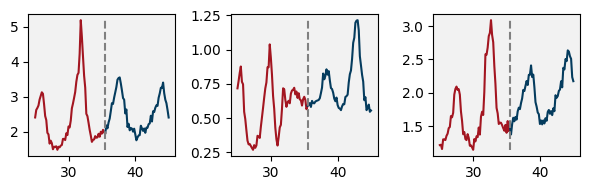

In [67]:
eps = 0.1
xlims = [25,45]
for cell in range(1):
    for nut_conc in nut_conc_vec_exp[3:-1:2]:
        fig, axs = plt.subplots(1,3, figsize=(6,2))
        for i in range(len(single_cell_phases)):
            ordered_subset = find_cell_at_phase0(dataset_exp,nut_conc,single_cell_phases[i])
            for num in np.arange(cell,cell+1):
                time = ordered_subset["time"][num]/6
                tstart_nut_exp = ordered_subset["time_nut_on"][num] / 6
                tend_nut_exp = ordered_subset["time_nut_off"][num] / 6
                p53_trace = ordered_subset["p53_trace"][num]
                print(ordered_subset["phase0"][num])
                time_pre_nutlin = np.logical_and(time>=xlims[0],time<=tstart_nut)
                time_post_nutlin = np.logical_and(time<=xlims[1],time>=tstart_nut-eps)
                time_pre_post_nutlin = np.logical_and(time<=xlims[1],time>=xlims[0])
                #axs[i].set_title(str(nut_conc))
                axs[i].plot(time[time_pre_nutlin],p53_trace[time_pre_nutlin], color = p53_color_pre_nutlin)
                axs[i].plot(time[time_post_nutlin],p53_trace[time_post_nutlin], color = p53_color_post_nutlin)
                axs[i].vlines(tstart_nut,min(p53_trace[time_pre_post_nutlin]),max(p53_trace[time_pre_post_nutlin]), "gray","--")
                axs[i].set_facecolor(color_background_exp)
        plt.tight_layout()
        plt.savefig("./Figures/Experimental_single_pulse_3cells.svg")
        plt.show()

## Figure 1E-1F

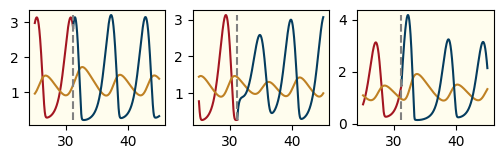

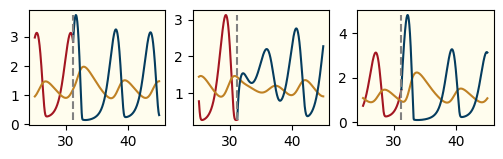

In [77]:

for nut_conc in nut_const_vec_model[1:-1:2]:
    fig, axs = plt.subplots(1,3, figsize=(6,1.5))
    for i in range(len(single_cell_phases)):
        ordered_subset = find_cell_at_phase0(dataset_model,nut_conc,single_cell_phases[i])
        time = ordered_subset["time"][0]
        tstart_nut = ordered_subset["time_nut_on"][0]
        tend_nut = ordered_subset["time_nut_off"][0]
        p53_trace = ordered_subset["p53_trace"][0]
        mdm2_trace = ordered_subset["mdm2_trace"][0]

        delta_t_start_nut = -tstart_nut+tstart_nut_exp
        xlims = [25,45] - delta_t_start_nut
        time_pre_nutlin = np.logical_and(time>xlims[0],time<tstart_nut)
        time_post_nutlin = np.logical_and(time<xlims[1],time>tstart_nut)
        time_pre_post_nutlin = np.logical_and(time<xlims[1],time>xlims[0])

        axs[i].plot(time[time_pre_nutlin]+delta_t_start_nut,p53_trace[time_pre_nutlin], color = p53_color_pre_nutlin)
        axs[i].plot(time[time_pre_post_nutlin]+delta_t_start_nut,mdm2_trace[time_pre_post_nutlin], color = mdm2_color)
        axs[i].plot(time[time_post_nutlin]+delta_t_start_nut,p53_trace[time_post_nutlin], color = p53_color_post_nutlin)
        axs[i].vlines(tstart_nut+delta_t_start_nut,min(p53_trace[time_pre_post_nutlin]),max(p53_trace[time_pre_post_nutlin]), "gray","--")
        axs[i].set_facecolor(color_background)
    plt.savefig("./Figures/Model_3single_cells"+str(nut_conc)+".svg")
    plt.show()

In [13]:
nut_conc = 1.25
for i in np.arange(20,39,1):
    plt.figure(figsize=(15,4))
    phase0 = dataset_model[dataset_model["nut_conc"]==nut_conc]["phase0"][i]
    phase1 = dataset_model[dataset_model["nut_conc"]==nut_conc]["phase1"][i]
    plt.title("Phase0:  "+str(round(phase0,2))+"  Phase1:  "+ str(round(phase1,2)))
    time = dataset_model[dataset_model["nut_conc"]==nut_conc]["time"][i]
    p53trace = dataset_model[dataset_model["nut_conc"]==nut_conc]["p53_trace"][i]
    plt.plot(time, p53trace)
    plt.vlines(dataset_model[dataset_model["nut_conc"]==nut_conc]["time_nut_on"][i], 0, 8)

KeyError: 20

<Figure size 1500x400 with 0 Axes>

# Visualize data

# Single pulse at different initial phases for two nutlin concentrations

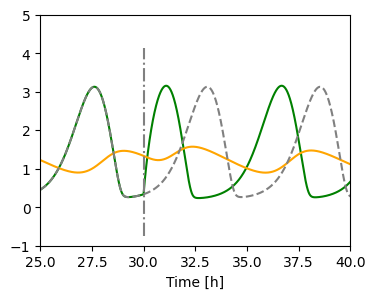

In [ ]:
# Simulation parameters
offset = 0

kc1, kc20,kc3,kc4,kc5,kc6,kc7 = unpack_Pars_list(Pars_exp)
kc8 = simulation_parameters['kc8']
simT = 60  #[h]
dt = 0.01 #1
t = np.arange(0, simT, dt)
#nut_min = 125 # Minimum nutlin given (125 nM)
#nut_const_vec_model = nut_min*np.array([2**i for i in range(5)])  # amplitude of nutlin pulse
x0 = [0, 0, 0] # Initial condition 
t_ON = 40/60 # [h]
t_OFF = simT
tstart_nut = simT/2+offset # Start of nutlin pulse [h]
tend_nut = simT #tstart_nut+t_ON #simT #tstart_nut+t_ON  # End of nutlin pulse [h]


x_unperturbed, kc2_unp = odeRungeKutta4_p53_single_pulse(f_p53,x0,dt,simT, 1, kc8, tstart_nut, tend_nut, kc1, kc20,kc3,kc4,kc5,kc6,kc7)
x_perturbed, kc2_per = odeRungeKutta4_p53_single_pulse(f_p53,x0,dt,simT, 0.4, kc8, tstart_nut, tend_nut, kc1, kc20,kc3,kc4,kc5,kc6,kc7)
# PLOT
plt.figure(figsize=(4,3))
#plt.plot(t,kc2_per, color = "tab:red", label = "kc2")
plt.plot(t,x_perturbed[:,2], color = "green", label = "p53")
plt.plot(t,x_perturbed[:,1], color = "orange", label = "Mdm2")
plt.plot(t,x_unperturbed[:,2], "--", color = "gray", label = "p53 unperturbed")
plt.vlines(tstart_nut,min(x_perturbed[-int(10/dt):,2])-1,max(x_perturbed[-int(10/dt):,2]+1), linestyle = "-.", color = "gray")
plt.xlim([25,40])
plt.ylim([-1,5])
#plt.legend()
plt.xlabel("Time [h]")
plt.show()

In [ ]:
def get_cell_info(dataset, nutlin_concentration, cell_id):
    cond1 = dataset["cell_id"]== cell_id
    cond2 = dataset["nut_conc"]== nutlin_concentration
    cond = cond1 & cond2

    subset = dataset.loc[cond].reset_index(drop=True)
    trace = subset["p53_trace"][0]
    time = subset["time"][0]/6
    tstart_nut = subset["time_nut_on"][0]/6
    tend_nut = subset["time_nut_off"][0]/6
    return trace, time, tstart_nut, tend_nut

def normalize_trace(trace):
    return (trace-np.mean(trace))/(max(trace)-min(trace))


def plot_single_cell_trace(dataset, cell_id, nutlin_concentration):
    trace, time, tstart_nut, tend_nut = get_cell_info(dataset, nutlin_concentration, cell_id)    

    # Plot p53 trace
    trace_toplot = normalize_trace(trace)
    plt.plot(time,trace_toplot,color="green")
    plt.title("Cell_id: "+str(cell_id)+ "  nutlin_conc: "+str(nutlin_concentration))
    tstart_nut = subset["time_nut_on"][0]/6
    tend_nut = subset["time_nut_off"][0]/6
    plt.vlines([tstart_nut,tend_nut],min(trace_toplot),max(trace_toplot),linestyle = "--",color="tab:grey")
    plt.xlabel("Time [min]")


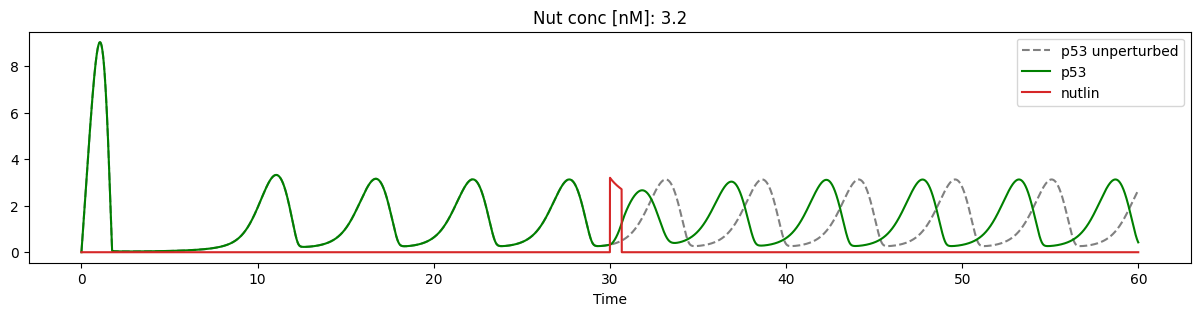

In [ ]:
# Plot a random cell in the dataset compared to unperturbed trace
cell = np.random.randint(50)
x_unperturbed = odeRungeKutta4_p53(f_p53, x0, dt, simT, tstart_nut, tend_nut, t_ON, t_OFF, nut_const = 0,
                               args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9,))

plt.figure(figsize=(15,3))
plt.plot(dataset_model["time"][cell][:], x_unperturbed[:,2], "--", color = "gray", label = "p53 unperturbed")
plt.plot(dataset_model["time"][cell][:], dataset_model["p53_trace"][cell][:], color = "green", label = "p53")
plt.plot(dataset_model["time"][cell][:], dataset_model["nut_trace"][cell][:], color = "tab:red", label = "nutlin")
plt.title("Nut conc [nM]: "+str(dataset_model["nut_conc"][cell]))
plt.xlabel("Time")
plt.legend()
plt.show()

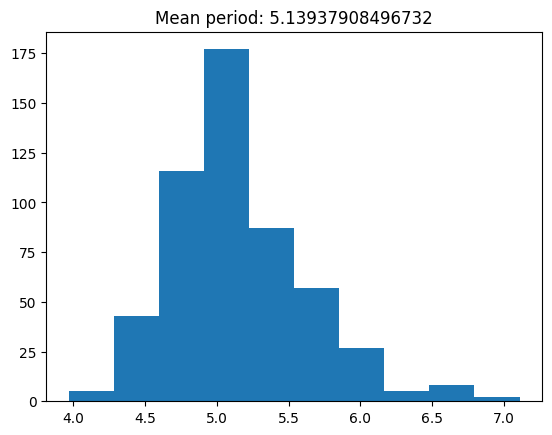

In [ ]:
plt.hist(dataset_exp["meanT"]/6)
plt.title("Mean period: "+str(np.mean(dataset_exp["meanT"]/6)))
plt.show()

In [ ]:
# Model
def find_cell_at_phase0(dataset,nut_conc,phase0,tolerance):
    cond1 = abs(dataset["phase0"]-phase0)<(tolerance*phase0)
    cond2 = dataset["nut_conc"]== nut_conc
    cond = cond1 & cond2
    subset = dataset.loc[cond].reset_index(drop=True)
    trace = subset["p53_trace"][0]
    time = subset["time"][0]
    tstart_nut = subset["time_nut_on"][0]
    tend_nut = subset["time_nut_off"][0]
    meanT = subset["meanT"][0]
    return trace, time, tstart_nut, tend_nut, meanT


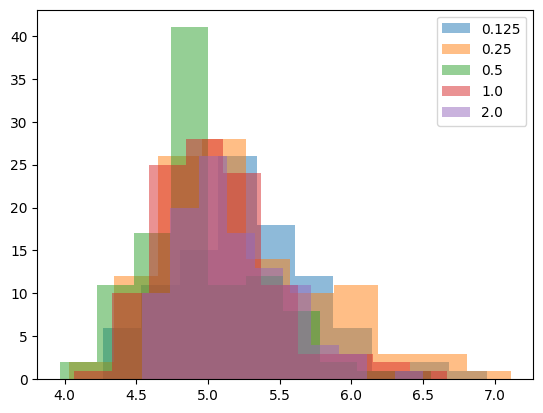

In [ ]:
conc_vec = [0.125, 0.25, 0.5, 1.0, 2.0]
for conc in conc_vec:
    cond = dataset_exp["nut_conc"]== conc
    subset = dataset_exp.loc[cond].reset_index(drop=True)
    meanT = subset["meanT"]
    plt.hist(meanT/6, alpha = 0.5, label = str(conc))
plt.legend()

In [ ]:
def subtract_poly_fit(time, trace, npol=1): # fit to polynomial of degree npol
    fy = np.polyfit(time,trace,npol) # fy are the coefficients in descending order
    nf = 0
    for i in range(npol+1):
        nf += fy[i]*time**(npol-i)
    # subtract from the original signal the polynomial fit
    return  trace-(nf)

def normalize_trace(trace,tmin,tmax):
    return (trace-np.mean(trace[tmin:tmax]))/(max(trace[tmin:tmax])-min(trace[tmin:tmax]))


# Match experiment and model at certain phase 0

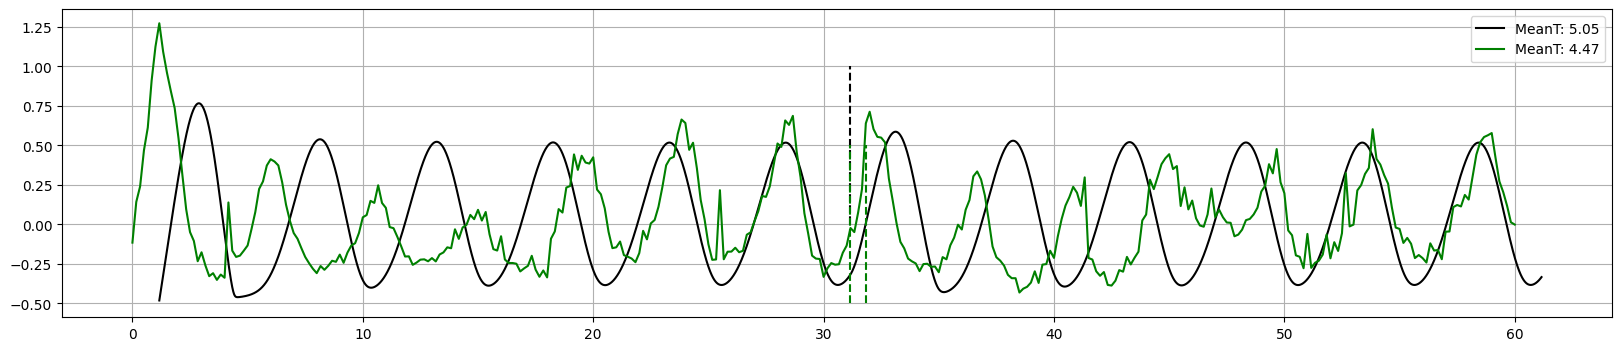

In [ ]:
phase0 = 6*np.random.rand()
tol = 0.1
trace_exp, time_exp, tstart_nut_exp, tend_nut_exp, meanT_exp = find_cell_at_phase0(dataset_exp,nut_conc =0.5,phase0 = phase0,tolerance = tol)
trace_mod, time_mod, tstart_nut_mod, tend_nut_mod, meanT_mod = find_cell_at_phase0(dataset_model,nut_conc = 500,phase0 = phase0,tolerance = tol)
trace_exp_without_trend = subtract_poly_fit(time_exp, trace_exp, npol=1)

plt.figure(figsize=(20,4))
plt.plot(time_mod-(tstart_nut_mod-tstart_nut_exp/6),normalize_trace(trace_mod,int(5/dt),int(25/dt)), color = "black", label = "MeanT: "+str(round(meanT_mod,2)))
plt.plot(time_exp/6,normalize_trace(trace_exp_without_trend, int(5*6),int(25*6)), color = "green",  label = "MeanT: "+str(round(meanT_exp/6,2)))
plt.vlines(tstart_nut_mod-(tstart_nut_mod-tstart_nut_exp/6), 0, 1, color = "black", ls = "--")
plt.vlines(tstart_nut_exp/6, -0.5, 0.5, color = "green", ls = "--")
plt.vlines(tend_nut_exp/6, -0.5, 0.5, color = "green", ls = "--")
plt.grid()
plt.legend()

# Ignore from here down

188


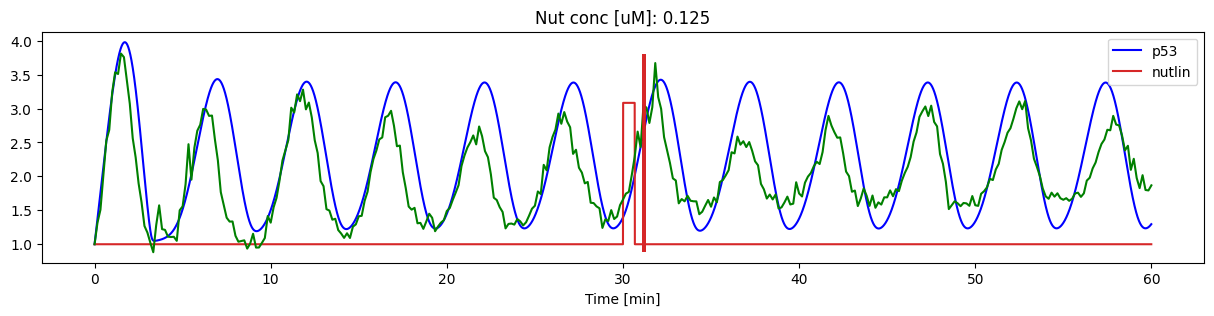

In [ ]:
# Plot a random cell in the dataset to see how it looks

plt.figure(figsize=(15,3))

# Plot a random cell in the dataset compared to unperturbed trace
cell_model = 0 #np.random.randint(100)
kc1, kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9 = unpack_Pars_list(Pars_old)
simT = 60  #[h]
dt = 0.01 #1
x_unperturbed = odeRungeKutta4_p53(f_p53, x0, dt, simT, tstart_nut, tend_nut, t_ON, t_OFF, nut_const = 0,
                               args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9,))
#plt.plot(dataset_model["time"][cell_model][:], (x_unperturbed[:,2]/120*2+1), "--", color = "gray", label = "p53 unperturbed")
plt.plot(dataset_model["time"][cell_model][:], dataset_model["p53_trace"][cell_model][:]/120*2+1, color = "blue", label = "p53")
plt.plot(dataset_model["time"][cell_model][:], dataset_model["nut_trace"][cell_model][:]/120*2+1, color = "tab:red", label = "nutlin")
plt.title("Nut conc [nM]: "+str(dataset_model["nut_conc"][cell_model]))
plt.xlabel("Time")
plt.legend()

cell_exp = np.random.randint(0,500) #102
print(cell_exp)
time = dataset_exp["time"][cell_exp][:]/6
p53 = dataset_exp["p53_trace"][cell_exp][:]
plt.plot(time, p53, color = "green")
plt.vlines(dataset_exp["time_nut_on"]/6,min(p53),max(p53), color = "tab:red")
plt.title("Nut conc [uM]: "+str(dataset_exp["nut_conc"][cell]))
plt.xlabel("Time [min]")
plt.show()


NameError: name 'subset' is not defined

<Figure size 2500x400 with 0 Axes>

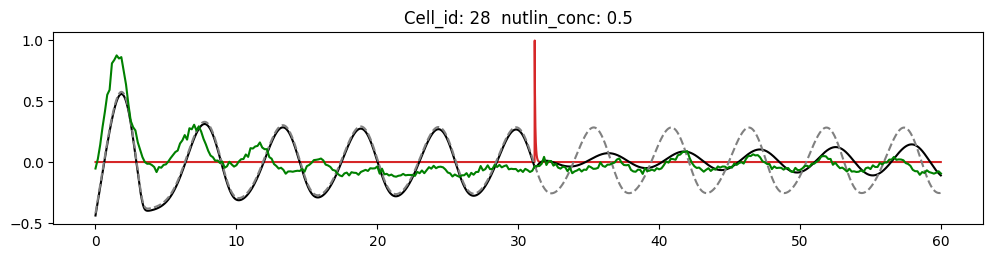

In [ ]:

plt.figure(figsize=(25,4))
cell_id = np.random.randint(100)
trace, time, tstart_nut_exp, tend_nut_exp = get_cell_info(dataset_exp, nutlin_concentration = 1.0, cell_id = cell_id)

# Simulation parameters
Pars_list = [Pars_old, Pars_new_chaos]
nut_const_vec = [85, 500] #
Titles = ["Old params", "New params"]
offset = [0.5,9]
for i,Pars in enumerate(Pars_list):
    kc1, kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9 = unpack_Pars_list(Pars)
    simT = 60  #[h]
    dt = 0.01 #1
    t = np.arange(0, simT, dt)
    #nut_min = 125 # Minimum nutlin given (125 nM)
    #nut_const_vec_model = nut_min*np.array([2**i for i in range(5)])  # amplitude of nutlin pulse
    x0 = [0, 0, 0, 0, 0] # Initial condition 
    t_ON = 40/60 # [h]
    t_OFF = simT
    tstart_nut = tstart_nut_exp #simT/2+offset[i] # Start of nutlin pulse [h]
    tend_nut = tstart_nut+t_ON  # End of nutlin pulse [h]

    x_unperturbed = odeRungeKutta4_p53(f_p53, x0, dt, simT, tstart_nut, tend_nut, t_ON, t_OFF, nut_const = 0,
                                args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9,))
    x_perturbed = odeRungeKutta4_p53(f_p53, x0, dt, simT, tstart_nut, tend_nut, t_ON, t_OFF, nut_const = nut_const_vec[i],
                                args = (kc1,kc2,kc3,kc4,kc5,kc6,kc7,kc8,kc9,))
    # PLOT
    plt.figure(figsize=(12,2.5))
    plt.plot(t,(x_perturbed[:,4]-np.mean(x_perturbed[:,4]))/(max(x_perturbed[:,4])-min(x_perturbed[:,4])), color = "tab:red", label = "Nutlin")
    plt.plot(t,(x_perturbed[:,2]-np.mean(x_perturbed[:,2]))/(max(x_perturbed[:,2])-min(x_perturbed[:,2])), color = "black", label = "p53")
    plt.plot(t,(x_unperturbed[:,2]-np.mean(x_unperturbed[:,2]))/(max(x_unperturbed[:,2])-min(x_unperturbed[:,2])), "--", color = "gray", label = "p53 unperturbed")

    plot_single_cell_trace(dataset_exp, cell_id = cell_id, nutlin_concentration = 0.5)

    plt.legend()
    plt.xlabel("Time [h]")
    plt.title(Titles[i])
    plt.show()
print("Cell id: ", cell_id)

plt.show()

trace, time, tstart_nut, tend_nut = get_cell_info(dataset_exp, nutlin_concentration, cell_id)  
mean = np.zeros(len(trace))
for cell_id in range(10):
    plot_single_cell_trace(dataset_exp, cell_id = cell_id, nutlin_concentration = 0.5)

    trace, time, tstart_nut, tend_nut = get_cell_info(dataset_exp, nutlin_concentration = 0.5, cell_id)    
    mean += trace

# Plot p53 trace
trace_toplot = normalize_trace(trace)
plt.plot(time,trace,color="green")
plt.title("Cell_id: "+str(cell_id)+ "  nutlin_conc: "+str(nutlin_concentration))
tstart_nut = subset["time_nut_on"][0]/6
tend_nut = subset["time_nut_off"][0]/6
plt.vlines([tstart_nut,tend_nut],min(trace_toplot),max(trace_toplot),linestyle = "--",color="tab:grey")
plt.xlabel("Time [min]")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


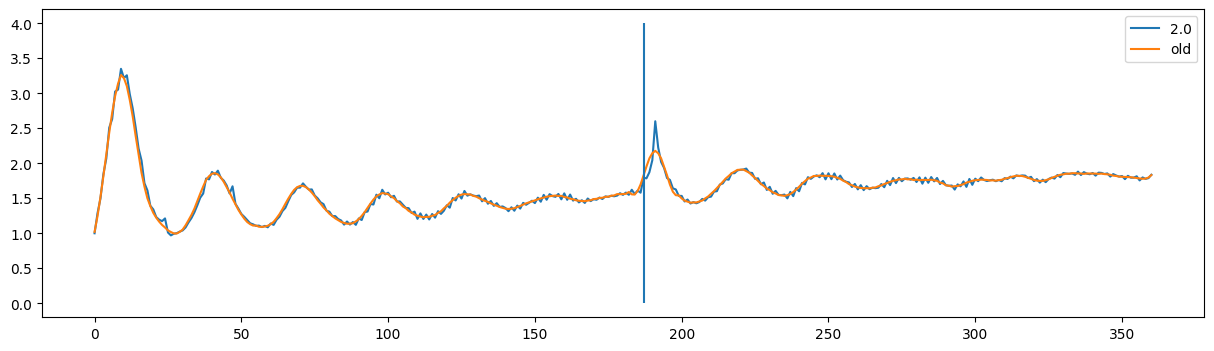

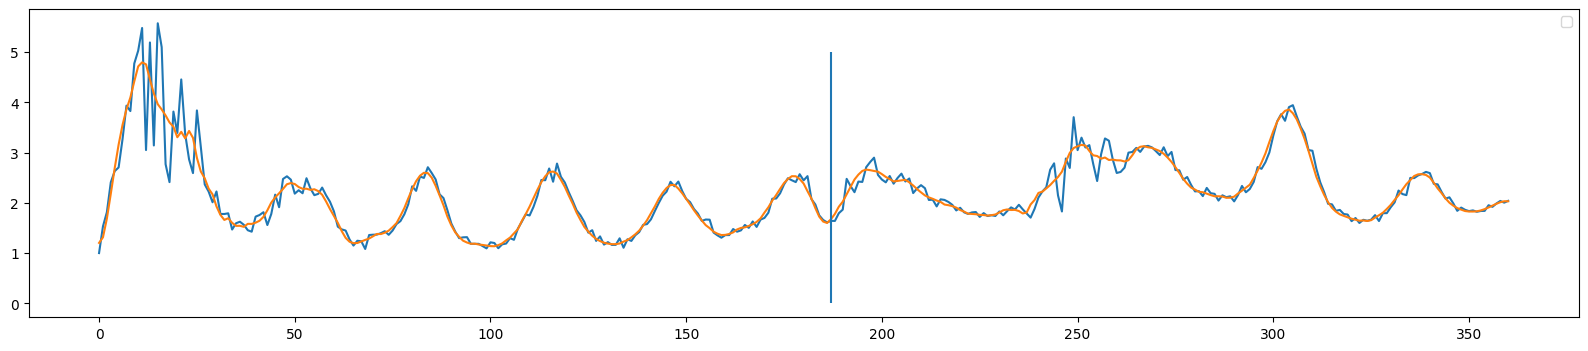

In [ ]:
plt.figure(figsize=(15,4))
#plt.plot(np.mean(dataset_exp[dataset_exp["nut_conc"]==0.25]["p53_trace"]), label = "0.25")
#plt.plot(np.mean(dataset_exp[dataset_exp["nut_conc"]==0.5]["p53_trace"]), label = "0.5")
#plt.plot(np.mean(dataset_exp[dataset_exp["nut_conc"]==1.0]["p53_trace"]), label = "1.0")
plt.plot(np.mean(dataset_exp[dataset_exp["nut_conc"]==0.5]["p53_trace"]), label = "2.0")
plt.plot(np.mean(dataset_exp[dataset_exp["nut_conc"]==0.5]["p53_trace_smooth"]), label = "old")
plt.legend()
plt.vlines([187], 0, 4)

plt.figure(figsize=(20,4))
ind = np.random.randint(450,480)
for i in range(1):
    plt.plot(dataset_exp[dataset_exp["nut_conc"]==2.0]["p53_trace"][i+ind])
    plt.plot(dataset_exp[dataset_exp["nut_conc"]==2.0]["p53_trace_smooth"][i+ind])
plt.legend()
plt.vlines(187,0,5)


In [ ]:
def smooth_filter(cell_info, nwindow = 18,nsmooth = 5): # smooth the function with gaussian filter
    trace = cell_info["p53_trace"]
    time = cell_info["time"]
#     filtered = lowess(trace, time, )
#     cell_info["p53_trace"] = filtered[:,1]
    ynew = []

    # Smooth the first segment
    ytmp = trace[:nwindow+1]
    xtmp = np.linspace(1, nwindow+1, nwindow+1)
    fyx = np.polyfit(xtmp, ytmp, nsmooth)
    f = np.polyval(fyx, xtmp)
    ynew.extend(f[:-1])

    # Smooth the middle segments
    for i in range(nwindow, len(trace)-nwindow):
        ytmp = trace[i-nwindow:i+nwindow+1]
        xtmp = np.linspace(1, 2*nwindow+1, 2*nwindow+1)
        fyx = np.polyfit(xtmp, ytmp, nsmooth)
        f = np.polyval(fyx, xtmp)
        ynew.append(f[nwindow])

    # Smooth the last segment
    ytmp = trace[len(trace)-nwindow:]
    xtmp = np.linspace(1,nwindow, nwindow)
    fyx = np.polyfit(xtmp, ytmp, nsmooth)
    f = np.polyval(fyx, xtmp)
    ynew.extend(f)
    cell_info["p53_trace_smooth"] = np.array(ynew)
    return cell_info